###  Load the dataset 

In [2]:
# Import necessary dependencies
import numpy as np
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import resample

import tensorflow as tf 


2024-05-04 12:50:17.529106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 12:50:17.529195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 12:50:17.615462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

# Adjust the path in the glob function to search through all 'images_*/images' directories
all_image_paths = {}
for i in range(1, 13):
    image_dir = f'/kaggle/input/data/images_{str(i).zfill(3)}/images/'
    image_paths = {os.path.basename(x): x for x in glob.glob(f'{image_dir}*.png')}
    all_image_paths.update(image_paths)

print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])

# Map the 'Image Index' column to the full path of the images
df['path'] = df['Image Index'].map(all_image_paths.get)


print(df.sample(3))


Scans found: 112120 , Total Headers 112120
            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
46548  00011894_003.png     No Finding            3       11894           22   
36856  00009708_001.png     No Finding            1        9708           67   
72389  00017835_023.png    Atelectasis           23       17835           48   

      Patient Gender View Position  OriginalImage[Width  Height]  \
46548              M            AP                 2500     2048   
36856              F            PA                 2992     2991   
72389              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
46548                        0.168  0.168          NaN   
36856                        0.143  0.143          NaN   
72389                        0.143  0.143          NaN   

                                                    path  
46548  /kaggle/input/data/images_006/images/00011894_...  
36856  /kagg

In [4]:
# Create a binary target column
df["Pneumonia"] = df["Finding Labels"].map(lambda x: 1. if "Pneumonia" in x else 0)

In [5]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_001/images/00000001_...,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/kaggle/input/data/images_001/images/00000002_...,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000003_...,0.0


### Original Class Distribution

In [6]:
# Original class distribution 
df["Pneumonia"].value_counts()

Pneumonia
0.0    110689
1.0      1431
Name: count, dtype: int64

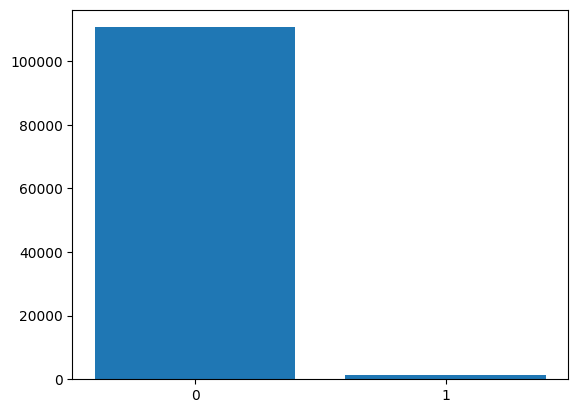

In [7]:
original_neg = df["Pneumonia"].value_counts()[0]
original_pos = df["Pneumonia"].value_counts()[1]
plt.bar([0, 1], [original_neg, original_pos])
plt.xticks(ticks=[0,1])
plt.show()

In [8]:
def create_splits(df, test_size=0.2):
    
    train_data, val_test_data = train_test_split(df, stratify=df.Pneumonia, test_size=test_size, shuffle=True, random_state=1000)
    
    return train_data, val_test_data

In [9]:
# Create initial splits
initial_train_data, initial_val_test_data = create_splits(df, test_size=0.35)

### Data Resampling 

#### Training Set 

In [10]:
# Initial train set distribution
initial_train_data["Pneumonia"].value_counts()

Pneumonia
0.0    71948
1.0      930
Name: count, dtype: int64

In [11]:
# Over-sample the positive class to obtain 4 times more
train_pos_resampled = resample(initial_train_data[initial_train_data["Pneumonia"] == 1], 
                              n_samples= len(initial_train_data[initial_train_data["Pneumonia"] == 1]) * 3,
                              random_state=1000)  

In [12]:
train_data = pd.concat([initial_train_data, train_pos_resampled])

In [13]:
# Under-sample the negative class to obtain 50/50 class ratio
train_neg_resampled = resample(train_data[train_data["Pneumonia"] == 0],
                               n_samples=train_data[train_data["Pneumonia"] == 1].shape[0],
                               random_state=1000)  

In [14]:
train_data = pd.concat((train_data[train_data["Pneumonia"] == 1], train_neg_resampled))

In [15]:
print(f'Training data: \n{train_data["Pneumonia"].value_counts()}')

Training data: 
Pneumonia
1.0    3720
0.0    3720
Name: count, dtype: int64


#### Validation and Test Set 

In [16]:
initial_val_test_data["Pneumonia"].value_counts()

Pneumonia
0.0    38741
1.0      501
Name: count, dtype: int64

Under-sample negative class to obtain 80/20 class ratio

In [17]:
# Under-sample the negative class to obtain 80/20 class ratio
val_test_neg_resampled = resample(initial_val_test_data[initial_val_test_data["Pneumonia"] == 0], 
                                  n_samples=initial_val_test_data[initial_val_test_data["Pneumonia"] == 1].shape[0] * 4 , 
                                  random_state=1000)

In [18]:
val_test_data = pd.concat((initial_val_test_data[initial_val_test_data["Pneumonia"] == 1], val_test_neg_resampled))

In [19]:
val_data, test_data = create_splits(val_test_data, test_size=0.5)

In [20]:
print(f'Validation data: \n{val_data["Pneumonia"].value_counts()}') 

Validation data: 
Pneumonia
0.0    1002
1.0     250
Name: count, dtype: int64


In [21]:
print(f'Testing data: \n{test_data["Pneumonia"].value_counts()}')

Testing data: 
Pneumonia
0.0    1002
1.0     251
Name: count, dtype: int64


Train/val/test ratio:       75/13/13


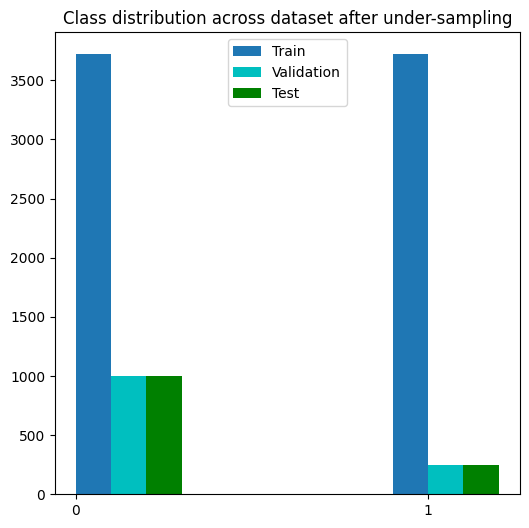

In [22]:
# Show final class distribution across all sets
plt.figure(figsize=(6,6))
plt.hist(train_data["Pneumonia"], label="Train")
plt.hist(val_data["Pneumonia"]+0.1, label="Validation", color='c') 
plt.hist(test_data["Pneumonia"]+0.2, label="Test", color='g') 
plt.xticks(ticks=[0,1])
plt.legend(loc="upper center")
plt.title("Class distribution across dataset after under-sampling")

all_data = len(train_data) + len(val_data) + len(test_data)
print(f'Train/val/test ratio: \
      {100*len(train_data)/all_data:.0f}/{100*len(val_data)/all_data:.0f}/{100*len(test_data)/all_data:.0f}')
plt.show()

### Data Augmentation and Normalization

In [23]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode='nearest',
                              brightness_range=[0.9,1.1])

In [24]:
val_test_idg = ImageDataGenerator(rescale=1. / 255.)

In [25]:
train_data['Pneumonia'] = train_data['Pneumonia'].astype(str)

In [26]:
train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                     directory=None, 
                                     x_col = 'path',
                                     y_col = 'Pneumonia',
                                     class_mode = 'binary',
                                     target_size = (224, 224), 
                                     batch_size = 64, 
                                     seed=1000)

Found 7440 validated image filenames belonging to 2 classes.


In [27]:
val_data['Pneumonia'] = val_data['Pneumonia'].astype(str)


In [28]:
val_gen = val_test_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = (224, 224), 
                                         batch_size = 64,
                                         seed=1000)

Found 1252 validated image filenames belonging to 2 classes.


In [29]:
test_data['Pneumonia'] = test_data['Pneumonia'].astype(str)

In [30]:
test_gen = val_test_idg.flow_from_dataframe(dataframe=test_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = (224, 224), 
                                         batch_size = 465,
                                         seed=1000)

Found 1253 validated image filenames belonging to 2 classes.


In [31]:
testX, testY = next(test_gen)


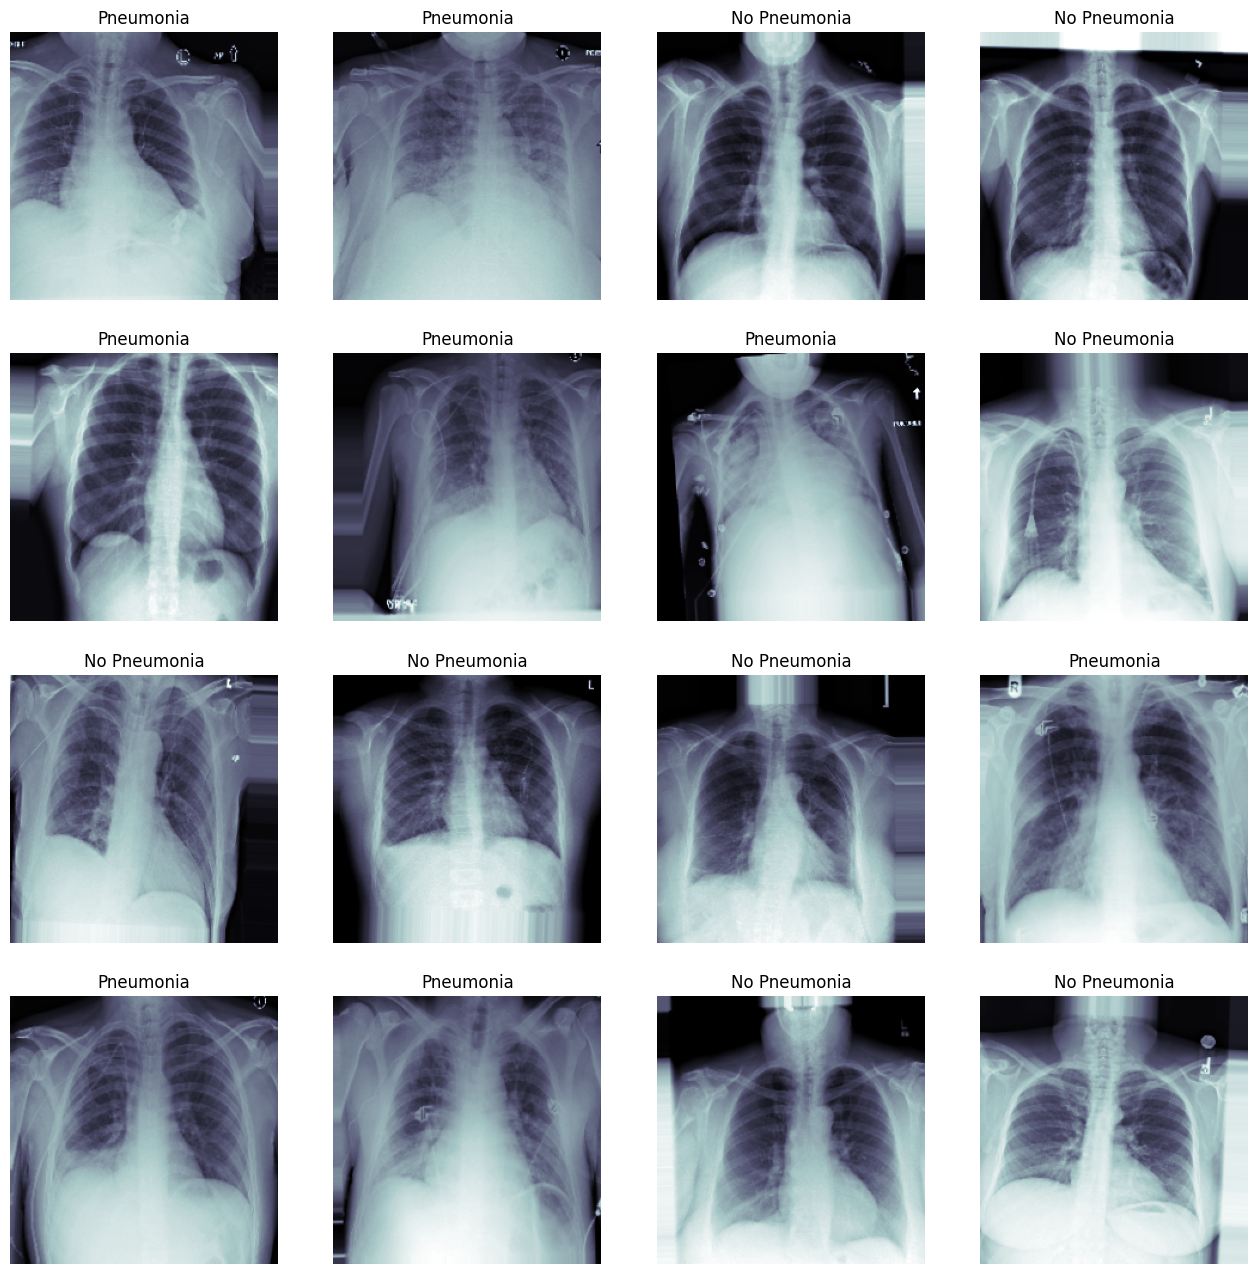

In [32]:
# Glimpse at the augmented data 
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

### Modelling & Training

In [36]:
def plot_history(history):
    
    # Convert the history object to a DataFrame
    hist = pd.DataFrame(history.history)
    
    # Plot loss function
    hist[['loss', 'val_loss']].plot()
    plt.title("Model loss during training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    # Plot accuracy 
    hist[['accuracy', 'val_accuracy']].plot()
    plt.title("Model accuracy during training")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

In [38]:
# Load pretrained VGG and freeze all but the last convolutional layer

def load_pretrained_model():
    
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    for layer in vgg_model.layers:
        if layer.name == "block5_conv3":
            layer.trainable = True
        else:
            layer.trainable = False
        
    return vgg_model

In [39]:
vgg_model = load_pretrained_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [41]:
def build_model(vgg_model, units=[128], dropout=0.2):
    x = GlobalAveragePooling2D()(vgg_model.output)

    for i in range(len(units)):
        x = Dense(units[i], activation="relu", name='fc'+str(i+1))(x)
        x = Dropout(dropout)(x)

    x = Dense(1, activation='sigmoid', name='predictions')(x)

    model = Model(inputs=vgg_model.input, outputs=x)

    optimizer = Adam(learning_rate=3e-3)
    
    
    loss = 'binary_crossentropy'


    model.compile(optimizer=optimizer, loss=loss,  metrics = ['accuracy'])

    return model


In [42]:
model = build_model(vgg_model, units=[512, 256, 128], dropout=0.5)

In [43]:
checkpoint = ModelCheckpoint("model.best.keras", # Changed from ".h5" to ".keras"
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=False)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.8, 
                              patience=4, 
                              verbose=1, 
                              mode='min', 
                              cooldown=5,
                              min_lr=0.0001)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=30)

callbacks_list = [checkpoint, early, lr_reduce]

In [44]:
history2 = model.fit(train_gen, 
                              validation_data = val_gen, 
                              epochs = 20,
                              callbacks = callbacks_list)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4990 - loss: 0.8690
Epoch 1: val_loss improved from inf to 0.71089, saving model to model.best.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.4991 - loss: 0.8679 - val_accuracy: 0.1997 - val_loss: 0.7109 - learning_rate: 0.0030
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5664 - loss: 0.6833
Epoch 2: val_loss did not improve from 0.71089
117/117 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.5666 - loss: 0.6832 - val_accuracy: 0.4752 - val_loss: 0.7813 - learning_rate: 0.0030
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6211 - loss: 0.6595
Epoch 3: val_loss improved from 0.71089 to 0.69278, saving model to model.best.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.6212 - loss: 0.6594 - val_accuracy: 0.5016 - val_loss: 0.6928 - learning_rate: 0.0030
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6536 - loss: 0.6333
Epoch 4: val_loss imp

In [45]:
model.load_weights('model.best.keras') 

In [46]:
for i, layer in enumerate(model.layers):
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(i, layer.name, filters.shape)

1 block1_conv1 (3, 3, 3, 64)
2 block1_conv2 (3, 3, 64, 64)
4 block2_conv1 (3, 3, 64, 128)
5 block2_conv2 (3, 3, 128, 128)
7 block3_conv1 (3, 3, 128, 256)
8 block3_conv2 (3, 3, 256, 256)
9 block3_conv3 (3, 3, 256, 256)
11 block4_conv1 (3, 3, 256, 512)
12 block4_conv2 (3, 3, 512, 512)
13 block4_conv3 (3, 3, 512, 512)
15 block5_conv1 (3, 3, 512, 512)
16 block5_conv2 (3, 3, 512, 512)
17 block5_conv3 (3, 3, 512, 512)


In [51]:
# Save model architecture
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [52]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


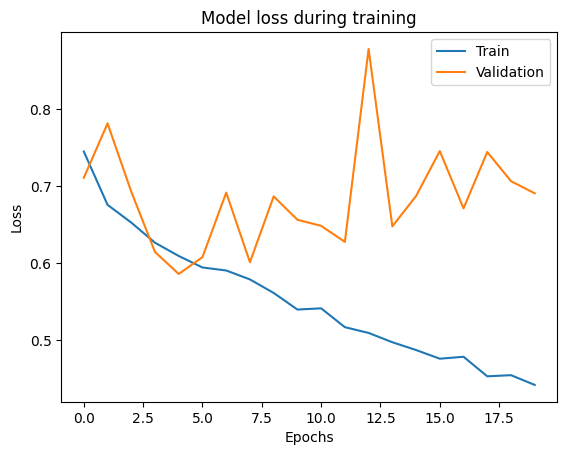

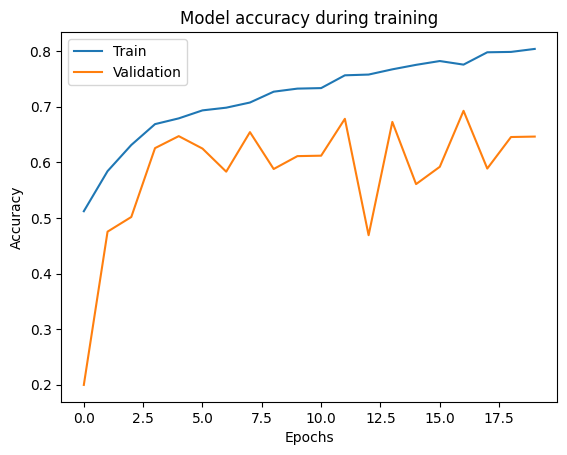

In [53]:
plot_history(history2)

In [54]:
save_model(model, "my_model3.h5")

### Training Performance

In [99]:
y_pred = model.predict(testX, verbose = True)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


In [100]:
print(y_pred)

[[0.45132038]
 [0.3797498 ]
 [0.68556917]
 [0.30779234]
 [0.07465801]
 [0.4329623 ]
 [0.2370208 ]
 [0.33528224]
 [0.19523121]
 [0.7113039 ]
 [0.440733  ]
 [0.16165179]
 [0.41270414]
 [0.41911006]
 [0.15583882]
 [0.16219561]
 [0.323929  ]
 [0.5621302 ]
 [0.5820478 ]
 [0.55598676]
 [0.12895538]
 [0.09581668]
 [0.11882164]
 [0.72589034]
 [0.3805782 ]
 [0.603742  ]
 [0.00796093]
 [0.48018208]
 [0.2975238 ]
 [0.6160505 ]
 [0.31901678]
 [0.19174571]
 [0.1909593 ]
 [0.5595504 ]
 [0.54656297]
 [0.6750163 ]
 [0.6918348 ]
 [0.46187413]
 [0.56108856]
 [0.30849984]
 [0.01122321]
 [0.27433437]
 [0.16493767]
 [0.5735689 ]
 [0.54464924]
 [0.5182066 ]
 [0.6627628 ]
 [0.49319592]
 [0.37913796]
 [0.09799755]
 [0.5820478 ]
 [0.3747026 ]
 [0.5617109 ]
 [0.44316238]
 [0.2056468 ]
 [0.56302583]
 [0.48037907]
 [0.5763191 ]
 [0.09771939]
 [0.664883  ]
 [0.61964697]
 [0.6397623 ]
 [0.06231664]
 [0.4060013 ]
 [0.03696135]
 [0.21677127]
 [0.48394614]
 [0.25478265]
 [0.12485141]
 [0.05420226]
 [0.5035336 ]
 [0.38

In [101]:
def f1_score(p, r):
    if(p == 0 or r == 0):
        return 0
    return 2 * p * r / (p + r)

Maximum F1 Score: 0.4104803493449781
Threshold for Maximum F1 Score: 0.5537287


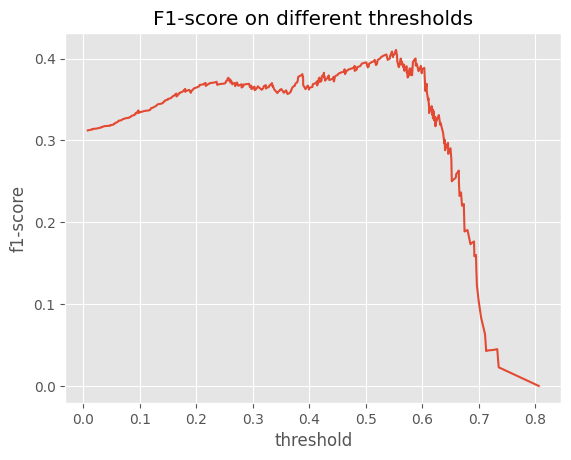

In [105]:
# Plot F1-score on different thresholds
precision, recall, thresholds = precision_recall_curve(testY, y_pred)
f1_scores = [f1_score(precision[i], recall[i]) for i in range(len(thresholds))]

max_f1_index = np.argmax(f1_scores)

# Get the maximum F1 score and its corresponding threshold
max_f1 = f1_scores[max_f1_index]
corresponding_threshold = thresholds[max_f1_index]

print("Maximum F1 Score:", max_f1)
print("Threshold for Maximum F1 Score:", corresponding_threshold)
# Choose the threshold that optimizes F1-score
thresh_idx = np.argmax(f1_scores)
thresh = thresholds[thresh_idx]

plt.figure()
plt.style.use("ggplot")
plt.plot(thresholds, f1_scores)
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('F1-score on different thresholds')
plt.show()

In [111]:

# Assuming y_pred contains predicted probabilities
threshold = 0.55
y_pred_class = (y_pred > threshold).astype(int)


In [86]:
# print(y_pred_class)

In [87]:
# print(testY)

In [116]:
precision = precision_score(testY, y_pred_class)
recall = recall_score(testY, y_pred_class)
f1 = f1_score(testY, y_pred_class)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.3219178082191781
Recall: 0.5465116279069767
F1 Score: 0.4051724137931034
